# Bike Routes in Denver

In this notebook, we load the bike routes of Denver.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import geonetworkx as gnx
import momepy # Used to build networks from GDF
import matplotlib.pyplot as plt
import csv

C:\Users\17347\Documents\Anaconda\envs\geo_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
bike_fac = gpd.read_file("existing_denver_bike_facilities.shp")

In [3]:
bike_fac_path_cat = pd.Categorical(bike_fac['EXISTING_F'])
bike_fac_path_cat
bike_fac['path_codes'] = bike_fac_path_cat.codes

Getting Distances of Paths in Meters

In [4]:
lines_bike_fac = bike_fac.explode(index_parts=True)

In [5]:
np.set_printoptions(suppress=True)
dist = list(lines_bike_fac.to_crs(3763).length)
dist = np.array(dist)
dist = dist.round(decimals = 2)
# dist

In [6]:
lines_bike_fac['lengths'] = dist

In [9]:
g_primal = momepy.gdf_to_nx(lines_bike_fac, approach = 'primal')
# positions = {n: [n[0], n[1]] for n in list(g_primal.nodes)}
# plt.figure(1,figsize=(50,50))
# nx.draw(g_primal,positions)
# plt.show()

C:\Users\17347\Documents\Anaconda\envs\geo_env\lib\site-packages\momepy\utils.py:235: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length


Relabelling nodes and edges

In [10]:
mapping = dict(zip(g_primal, range(1, len(list(g_primal.nodes))+1)))
G_labels = nx.relabel_nodes(g_primal, mapping)

In [11]:
# current format is "tail, head, edge label"
edges = np.array(list(G_labels.edges))

Get path category and distance data from each edge

In [12]:
lengths = []
path_cat = []
for i in range(len(edges)):
    lengths.append(G_labels.get_edge_data(edges[i,0],edges[i,1]).get(edges[i,2]).get('lengths'))
    path_cat.append(G_labels.get_edge_data(edges[i,0],edges[i,1]).get(edges[i,2]).get('path_codes'))

combine edge data into sinlg np.array

In [13]:
add_dists = np.concatenate((edges[:,:2], np.array(lengths).reshape(len(lengths),1)), 1)
all_edge_data = np.concatenate((add_dists, np.array(path_cat).reshape(len(path_cat),1)), 1)
all_edge_data

array([[   1.  ,    2.  , 1105.85,    4.  ],
       [   1.  ,   46.  ,  372.7 ,    4.  ],
       [   3.  ,    4.  ,  353.07,    4.  ],
       ...,
       [1110.  , 1112.  ,  468.6 ,    2.  ],
       [1113.  , 1113.  ,  568.98,    1.  ],
       [1113.  , 1114.  , 1919.15,    1.  ]])

Put node labels in np.array

In [14]:
nodes = np.array(list(G_labels.nodes))
nodes

array([   1,    2,    3, ..., 1112, 1113, 1114])

In [ ]:
# edgesdf = pd.DataFrame(all_edge_data)
# nodesdf = pd.DataFrame(nodes)
  
# # save the dataframe as a csv file
# edgesdf.to_csv("edge_data.csv")
# nodesdf.to_csv("node_data.csv")

## New Edge Data Node Correction

In [15]:
node_data = pd.read_csv('cleaned_coords.csv')

In [16]:
nodes = pd.DataFrame(np.array(range(0,len(node_data))))
node_data['node'] = nodes
# node_data

In [17]:
edge_data = pd.read_csv ('cleaned_edges.csv')

In [18]:
edge_data.columns
edge_data = edge_data.rename(columns={'my_edges.from': 'tail', 'my_edges.to': 'head','my_edges.EXISTING_F': 'existing_f', 'my_edges.FULLNAME': 'fullname','my_edges.FROMNAME': 'fromname', 'my_edges.TONAME': 'toname'})
edge_data['tail']-=1
edge_data['head']-=1

In [19]:
edge_data['existing_f'] = edge_data['existing_f'].fillna('Shared Use Path')

In [20]:
from shapely.geometry import Point
from shapely.geometry import LineString
startlat = []
endlat=[]
startlong=[]
endlong=[]
for i in range(0, len(edge_data)):
    startlat.append(node_data['X'][edge_data['tail'][i]])
    startlong.append(node_data['Y'][edge_data['tail'][i]])
    endlat.append(node_data['X'][edge_data['head'][i]])
    endlong.append(node_data['Y'][edge_data['head'][i]])

start = [Point(xy) for xy in zip(startlat, startlong)]    
end = [Point(xy) for xy in zip(endlat, endlong)] 
edge_data['start'] = start
edge_data['end'] = end

C:\Users\17347\Documents\Anaconda\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
C:\Users\17347\Documents\Anaconda\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [21]:
edge_data['line'] = edge_data.apply(lambda row: LineString([row['start'], row['end']]), axis=1) #Create a linestring column

# # Zip the coordinates into a point object and convert to a GeoDataFrame
# geometry = [Point(xy) for xy in zip(startlong, startlat)]
# df = GeoDataFrame(edge_data, geometry=geometry)

# # Aggregate these points with the GroupBy
# df = df.groupby(['entity_id'])['geometry'].apply(lambda x: LineString(x.tolist()))
# df = GeoDataFrame(df, geometry='geometry')

C:\Users\17347\Documents\Anaconda\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [22]:
edge_data_geo = gpd.GeoDataFrame(edge_data, geometry='line')
edge_data_geo.crs = "EPSG:4326"
# edge_data

In [23]:
np.set_printoptions(suppress=True)
dist = list(edge_data_geo.to_crs(3763).length)
dist = np.array(dist)
dist = dist.round(decimals = 2)
dist

array([1110.51,  304.38, 1243.97, ...,  602.57, 1006.12,  829.88])

In [24]:
bike_fac_path_cat = pd.Categorical(edge_data['existing_f'])
print(bike_fac_path_cat)
edge_data['path_codes'] = bike_fac_path_cat.codes
edge_data['dist'] = dist
# edge_data

['Shared Roadway', 'Bike Lane', 'Bike Lane', 'Bike Lane', 'Bike Lane', ..., 'Shared Use Path', 'Shared Use Path', 'Shared Use Path', 'Shared Use Path', 'Shared Use Path']
Length: 1245
Categories (7, object): ['Bike Lane', 'Buffered Bike Lane', 'Neighborhood Bikeway', 'Protected Bike Lane', 'Shared Roadway', 'Shared Use Path', 'Trail']


In [25]:
final_edge_data = []
final_edge_data = pd.DataFrame(final_edge_data)
final_edge_data['tail'] = edge_data['tail']
final_edge_data['head'] = edge_data['head']
final_edge_data['dist'] = edge_data['dist']
final_edge_data['path_code'] = edge_data['path_codes']

In [26]:
#edge_data_for plotting purposes
plot_edge_data = []
plot_edge_data = pd.DataFrame(final_edge_data)
plot_edge_data['tail'] = edge_data['tail']
plot_edge_data['head'] = edge_data['head']
plot_edge_data['dist'] = edge_data['dist']
plot_edge_data['path_code'] = edge_data['path_codes']
plot_edge_data['lines'] = np.array(edge_data['line'])

Save to CSV

In [ ]:
final_edge_data.to_csv("edge_data_updated.csv")

In [ ]:
edge_data_geo.to_csv("plot_edge_data.csv")

In [ ]:
nodes.to_csv("node_data_updated.csv")

In [ ]:
node_data.to_csv("plot_node_data.csv")

## Getting Nodes Closest to Points of Interst

In [27]:
points_of_interest = pd.DataFrame(columns = ['name', 'X', 'Y'])
points_of_interest['name'] = ['Auraria Campus', 'Union Station', 'City Park', 'DU', 'Denver Central Market']
points_of_interest['Y'] = [39.742840,39.7492941,39.733082,39.676610,39.759491]
points_of_interest['X'] = [-105.006710,-104.995010,-104.952377,-104.959510,-104.984657]

In [28]:
closest_node = np.zeros(len(points_of_interest))
closest_node = closest_node + 100000000000
min_dist = np.zeros(len(points_of_interest))
min_dist = min_dist + 1000000000000
geometry_nodes = gpd.points_from_xy(node_data.X, node_data.Y, crs="EPSG:4326")
geometry_locs = gpd.points_from_xy(points_of_interest.X, points_of_interest.Y, crs="EPSG:4326")
for j in range(len(points_of_interest)):
    for i in range(len(node_data)):
        if (geometry_nodes[i].distance(geometry_locs[j]) < min_dist[j]):
            min_dist [j] = geometry_nodes[i].distance(geometry_locs[j])
            closest_node[j] = i
    
    

In [29]:
for i in range(len(points_of_interest)):
    print('location:', points_of_interest['name'][i],'node:',closest_node[i])

location: Auraria Campus node: 26.0
location: Union Station node: 433.0
location: City Park node: 834.0
location: DU node: 427.0
location: Denver Central Market node: 112.0


## Making Plots of Shortest Paths

In [30]:
auraria_path = np.array(pd.read_csv('shortest_path_res/auraria_res.csv'))
du_path= np.array(pd.read_csv('shortest_path_res/DU_res.csv'))
dcm_path= np.array(pd.read_csv('shortest_path_res/DCM_res.csv'))
citypark_path= np.array(pd.read_csv('shortest_path_res/citypark_res.csv'))
union_path= np.array(pd.read_csv('shortest_path_res/union_res.csv'))

In [31]:
edge_data_geo = gpd.GeoDataFrame(edge_data, geometry = edge_data['line'])

In [32]:
all_dest_paths = []

In [33]:
def convert_to_path(table):
    all_paths = []
    sink = np.where(table[:,1]==0.0)
    sink = sink[0]

    for i in range(len(table)):
        source = table[i,0]
        pred_path = []
        path(source, sink, table, pred_path)
        all_paths.append(pred_path)
    return all_paths

In [34]:
def path(source, sink, path_array, pred_path):
    next_node = (np.where(path_array[:,0]==source))
    if(path_array[next_node[0],2] != source):
        pred_path.append(source)
        source = path_array[next_node[0],2][0]
        path(source, sink, path_array, pred_path)

In [35]:
def remove_subpaths(paths):
    sets = [set(l) for l in paths]
    uniq_paths = [l for l,s in zip(paths, sets) if not any(s < other for other in sets)]
    return uniq_paths

In [36]:
def path_plot(paths, all_edges):
    plt.figure()
    for j in paths:
        shortest_path = []
        for i in range(len(j)-1):
            if(all_edges[(all_edges['tail'] == j[i]) & (all_edges['head']==j[i+1])].line.empty):
                shortest_path.append(all_edges[(all_edges['head'] == j[i]) & (all_edges['tail']==j[i+1])].line)
            else:
                shortest_path.append(all_edges[(all_edges['tail'] == j[i]) & (all_edges['head']==j[i+1])].line)

        shortest_path_df = pd.DataFrame(data = np.array(shortest_path), columns = ['lines'])
        shortest_path_geo_df = gpd.GeoDataFrame(shortest_path_df, geometry=shortest_path_df['lines'])

        
        f, ax = plt.subplots(1, 1, figsize=(18, 6), sharex=True, sharey=True)
        edge_data_geo.plot(color='black', ax=ax, zorder=-1)
        shortest_path_geo_df.plot(ax=ax,color = 'green', linewidth=5)
        ax.axis("off")
    ax.plot()

In [38]:
table = auraria_path
# table = du_path
# table = dcm_path
# table = citypark_path
# table = union_path
converted_paths = convert_to_path(table)
uniq_paths = remove_subpaths(converted_paths)
# path_plot(uniq_paths,edge_data_geo)

C:\Users\17347\AppData\Local\Temp\ipykernel_16640\1100381811.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if(path_array[next_node[0],2] != source):


list

In [51]:
# pd.DataFrame(uniq_paths).to_csv("auraria_sp.csv")
with open("auraria_sp.csv","w") as f:
    writer = csv.writer(f,delimiter = ',')
    writer.writerows(converted_paths)

In [ ]:
all_dest_paths.extend(uniq_paths)
# all_dest_paths = uniq_paths
print(len(all_dest_paths))

In [ ]:
converted_paths

## Get Edges from Shortest Paths

In [26]:
def path_edges(paths):
    path_edges = []
    for j in paths:
#         shortest_path = np.zeros((len(j)-1,2))
        for i in range(len(j)-1):
            path_edges.append([j[i],j[i+1]])
    return path_edges

In [ ]:
short_path_edges = path_edges(all_dest_paths)

In [ ]:
values, counts = np.unique(np.array(short_path_edges), return_counts=True, axis = 0)

In [ ]:
edges=[]
types = []
for i in range(len(values)):
    if(edge_data_geo[(edge_data_geo['tail'] == values[i,0]) & (edge_data_geo['head']==values[i,1])].line.empty):
        edges.append(edge_data_geo[(edge_data_geo['head'] == values[i,0]) & (edge_data_geo['tail']==values[i,1])].line)
        types.append(edge_data_geo[(edge_data_geo['head'] == values[i,0]) & (edge_data_geo['tail']==values[i,1])].existing_f)
    else:
        edges.append(edge_data_geo[(edge_data_geo['tail'] == values[i,0]) & (edge_data_geo['head']==values[i,1])].line)
        types.append(edge_data_geo[(edge_data_geo['tail'] == values[i,0]) & (edge_data_geo['head']==values[i,1])].existing_f)

        edges_df = pd.DataFrame(data = np.array(edges), columns = ['lines'])
edges_df['counts'] = counts
edges_df['path_codes'] = np.array(types)
conditions_1 = [(edges_df['path_codes']=='Bike Lane'),
              (edges_df['path_codes']=='Buffered Bike Lane'),
              (edges_df['path_codes']=='Neighborhood Bikeway'),
              (edges_df['path_codes']=='Protected Bike Lane'),
              (edges_df['path_codes']=='Shared Roadway'),
              (edges_df['path_codes']=='Shared Use Path'),
              (edges_df['path_codes']=='Trail')]
colors = ['#FE6100','#DC267F','#785EF0','#DC267F','#FFB000','#648FFF','#648FFF'] #orange, pink, purple, yellow, blue
edges_df['color'] = np.select(conditions_1, colors)
conditions_2 = [(edges_df['counts']<=20),
              ((edges_df['counts']>20) & (edges_df['counts']<=50)),
              ((edges_df['counts']>50) & (edges_df['counts']<=100)),
              ((edges_df['counts']>100) & (edges_df['counts']<=200)),
               ((edges_df['counts']>200) & (edges_df['counts']<=300))]
vals = ['#0037C7','#5A82F3','#1EBED6','#FF5757','#FF0000'] #dark blue to dark red
edges_df['freq'] = np.select(conditions_2, vals)
edges_geo_df = gpd.GeoDataFrame(edges_df, geometry=edges_df['lines'])

In [ ]:
#Path Codes
#0:Bike Lane #FE6100 orange
#1:Buffered Bike Lane #DC267F pink
#2:Neighborhood Byway #785EF0 purple
#3:Protect Bike Lane #DC267F pink
#4:Shared Roadway #FFB000 yellow
#5:Shared Use Path #648FFF blue
#6:Trail #648FFF blue

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(20, 20), sharex=True, sharey=True)
all_edges = edge_data_geo.plot(linewidth = 5,color='black', ax=ax, zorder=-1)
sp_edges = edges_geo_df.plot(column='path_codes',color = edges_geo_df['color'], ax = ax, linewidth = 7, zorder = 1,legend = True)
dest_pts = (gpd.GeoDataFrame(geometry_locs, geometry=geometry_locs)).plot(markersize = 300,color = 'Black', ax = ax, zorder = 2)
ax.axis("off")
plt.title('Types of Edges in Regular Shortest Paths', fontsize = 30)
plt.savefig('sp_path_types.png')
plt.show()

## Tau Shortest Paths

### Cautious

In [28]:
def row_conversion(csvreader):
    rows = []
    for row in csvreader:
        arr = np.array(row, dtype=int)
        rows.append(list(arr))
    return rows

In [36]:
all_tau_paths = []

In [47]:
# auraria_tau_c = csv.reader(open('tau_results/auraria_tau_cautious_paths.csv'), delimiter=',')
# du_tau_c = csv.reader(open('tau_results/DU_tau_cautious_paths.csv'), delimiter=',')
# dcm_tau_c = csv.reader(open('tau_results/5points_tau_cautious_paths.csv'), delimiter=',')
# citypark_tau_c = csv.reader(open('tau_results/citypark_tau_cautious_paths.csv'), delimiter=',')
union_tau_c = csv.reader(open('tau_results/union_tau_cautious_paths.csv'), delimiter=',')

In [48]:
# paths = row_conversion(auraria_tau_c)
# paths = row_conversion(du_tau_c)
# paths = row_conversion(dcm_tau_c)
# paths = row_conversion(citypark_tau_c)
paths = row_conversion(union_tau_c)
uniq_tau_paths = remove_subpaths(paths)
# tau_path_plot(uniq_paths_tau,edge_data_geo, [], [])

In [49]:
all_tau_paths.extend(uniq_tau_paths)
len(all_tau_paths)

242

In [62]:
tau_path_edges = path_edges(all_tau_paths)
values_tau, counts_tau = np.unique(np.array(tau_path_edges), return_counts=True, axis = 0)

In [72]:
counts_tau.max()

68

In [74]:
edges_geo_df = tau_path_plot(edge_data_geo,values_tau, counts_tau)

In [73]:
def tau_path_plot(edge_data, values_tau, counts_tau):
    edges = []
    types = []
    for i in range(len(values_tau)):
        if(edge_data[(edge_data['tail'] == values_tau[i,0]) & (edge_data['head']==values_tau[i,1])].line.empty):
            edges.append(edge_data[(edge_data['head'] == values_tau[i,0]) & (edge_data['tail']==values_tau[i,1])].line)
            types.append(edge_data[(edge_data['head'] == values_tau[i,0]) & (edge_data['tail']==values_tau[i,1])].existing_f)
        else:
            edges.append(edge_data[(edge_data['tail'] == values_tau[i,0]) & (edge_data['head']==values_tau[i,1])].line)
            types.append(edge_data[(edge_data['tail'] == values_tau[i,0]) & (edge_data['head']==values_tau[i,1])].existing_f)

    edges_df = pd.DataFrame(data = np.array(edges), columns = ['lines'])
    edges_df['counts'] = counts_tau
    edges_df['path_codes'] = np.array(types)
    conditions_1 = [(edges_df['path_codes']=='Bike Lane'),
                  (edges_df['path_codes']=='Buffered Bike Lane'),
                  (edges_df['path_codes']=='Neighborhood Bikeway'),
                  (edges_df['path_codes']=='Protected Bike Lane'),
                  (edges_df['path_codes']=='Shared Roadway'),
                  (edges_df['path_codes']=='Shared Use Path'),
                  (edges_df['path_codes']=='Trail')]
    colors = ['#FE6100','#DC267F','#785EF0','#DC267F','#FFB000','#648FFF','#648FFF'] #orange, pink, purple, yellow, blue
    edges_df['color'] = np.select(conditions_1, colors)
    conditions_2 = [(edges_df['counts']<=10),
                  ((edges_df['counts']>10) & (edges_df['counts']<=20)),
                  ((edges_df['counts']>20) & (edges_df['counts']<=30)),
                  ((edges_df['counts']>30) & (edges_df['counts']<=40)),
                   ((edges_df['counts']>40) & (edges_df['counts']<=70))]
    vals = ['#0037C7','#5A82F3','#1EBED6','#FF5757','#FF0000'] #dark blue to dark red
    edges_df['freq'] = np.select(conditions_2, vals)
    edges_geo_df = gpd.GeoDataFrame(edges_df, geometry=edges_df['lines'])
    return edges_geo_df

C:\Users\17347\Documents\Anaconda\envs\geo_env\lib\site-packages\geopandas\plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


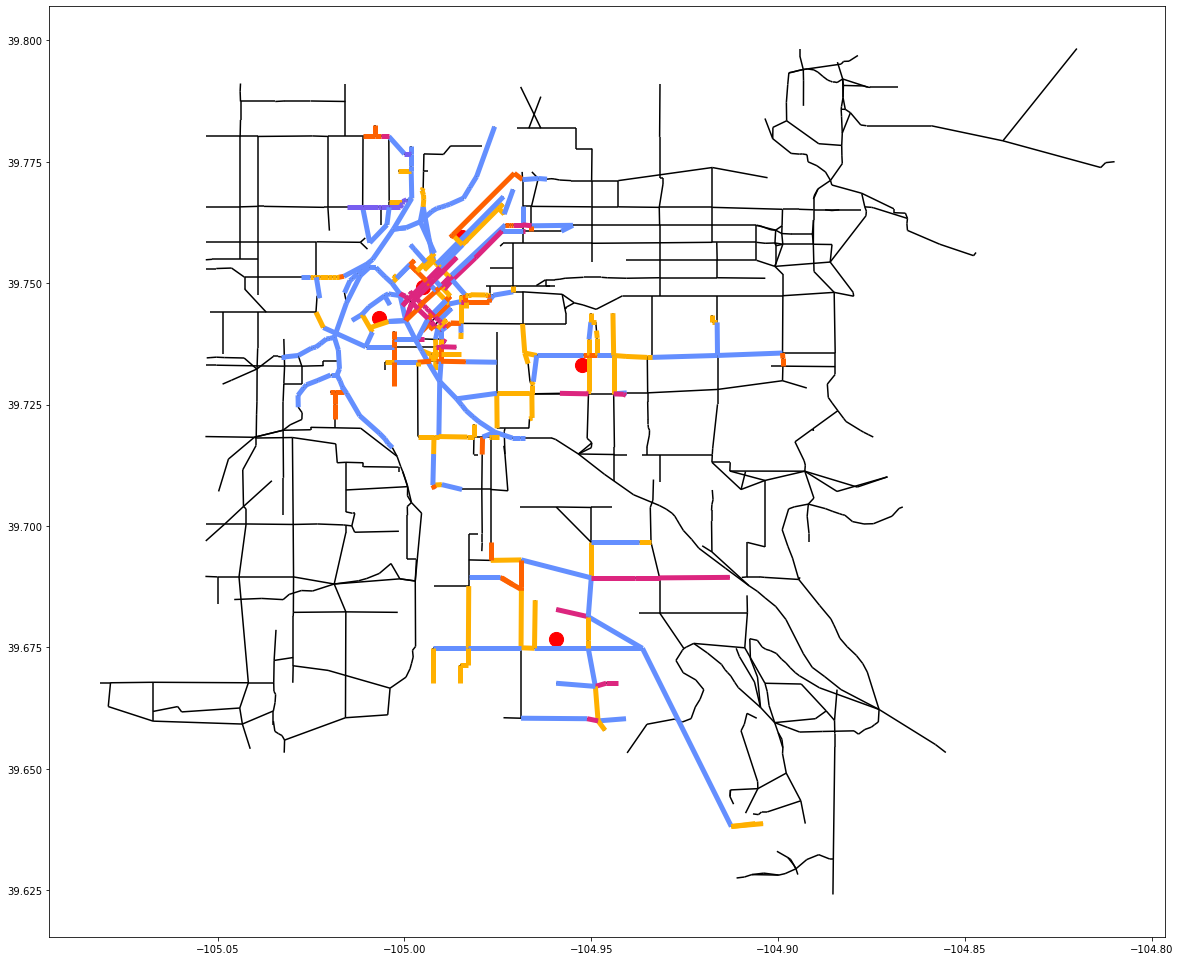

In [76]:
f, ax = plt.subplots(1, 1, figsize=(20, 20), sharex=True, sharey=True)
edge_data_geo.plot(color='black', ax=ax, zorder=-1)
edges_geo_df.plot(column='path_codes',color = edges_geo_df['color'], ax = ax, linewidth = 5)
(gpd.GeoDataFrame(geometry_locs, geometry=geometry_locs)).plot(markersize = 200,color = 'red', ax = ax)
plt.show()